## Amazon Fine Food Review - Naive Bayes

### 1. Objective

                To find a Review whether Positive or Negative

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [7]:
raw_text_data=filter_data["Text"].values

In [8]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:37<00:00, 703.84it/s]


In [10]:
filter_data["Text"]=preprocessed_text_data

In [11]:
filter_data.shape

(364171, 10)

In [12]:
# we took the sample data size as 150k 

final_data=filter_data[:350000]
final_data.shape

(350000, 10)

### 4. Data Splitting

In [13]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [14]:
X=final_data.Text
Y=final_data.Score

In [15]:
x_1,x_test,y_1,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train,x_cv,y_train,y_cv=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train.shape,y_train.shape)

print("cv data size")
print(x_cv.shape,y_cv.shape)
print("Test data size")
print(x_test.shape,y_test.shape)

 Train data Size
(210000,) (210000,)
cv data size
(70000,) (70000,)
Test data size
(70000,) (70000,)


### 5. Featurization

* We only consider BOW and TFIDF. Because the Naive Bayes biggest assumption is Conditional independence. 

#### 5.1 Bag of Words (BOW)

In [16]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [17]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5)

# BOW on Train data

bow_train_vec1=bow_model.fit_transform(x_train)

# BOW on cv data

bow_cv_vec1=bow_model.transform(x_cv)

# BOW on Test data

bow_test_vec1=bow_model.transform(x_test)

In [18]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec1.get_shape()[1])

The size of BOW vectorizer
258785


#### 5.2 TFIDF

In [19]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5)

# TFIDF on Train data 

tfidf_train_vec1=tfidf_model.fit_transform(x_train)

# TFIDF on cv data

tfidf_cv_vec1=tfidf_model.transform(x_cv)

# TFIDF on Test data

tfidf_test_vec1=tfidf_model.transform(x_test)

In [21]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape()[1])

The size of TFIDF vectorizer
258785


### 6. Naive Bayes Model

* We take Multinomial Naive Bayes(NB), Becuase in BOW and TFIDF are represented word by using word counts 

#### 6.1 Creating Function for Naive Bayes Model:

In [22]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import math

In [23]:
# References for Python Functions:
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/function-arguments/
# https://www.geeksforgeeks.org/functions-in-python/
# https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

# Fuction for Hyper parameter Tuning

def multinomial_NB(**para):
    
    auc_train=[]
    auc_cv=[]
    for i in tqdm(para['alpha_values']):
        MNB_model=MultinomialNB(alpha=i)
        MNB_model.fit(para['train_vector'],para['train_label'])
    
        # Prediction of training data

        MNB_train_proba =MNB_model.predict_proba(para["train_vector"])
        train=roc_auc_score(para["train_label"],MNB_train_proba[:,1])
        auc_train.append(train)

        # Prediction of cv data

        MNB_cv_proba=MNB_model.predict_proba(para["cv_vector"])
        cv=roc_auc_score(para["cv_label"],MNB_cv_proba[:,1])
        auc_cv.append(cv)
    
    # Return values
    
    return auc_train,auc_cv

In [24]:
# References
# Futrure Importance: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes


# Function for Apply best hyperparameter

def best_NB (**para):
    
    # Model training
    MNB_model=MultinomialNB(alpha=para["best_alpha"])
    MNB_model.fit(para["train_vector"],para["train_label"])

    # Feature importance
    
    class_return=MNB_model.classes_
    fi=MNB_model.feature_log_prob_
    
    # training data
    
    MNB_train_proba=MNB_model.predict_proba(para["train_vector"])
    train_proba=MNB_train_proba
    fpr_train,tpr_train,thres_train=roc_curve(para["train_label"],MNB_train_proba[:,1])
    auc_train=roc_auc_score(para["train_label"],MNB_train_proba[:,1])
    
    # test data
    
    MNB_test_proba=MNB_model.predict_proba(para["test_vector"])
    test_proba=MNB_test_proba
    fpr_test,tpr_test,thres_test=roc_curve(para["test_label"],MNB_test_proba[:,1])
    auc_test=roc_auc_score(para["test_label"],MNB_test_proba[:,1])
    
    return train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi

In [25]:
# References
# https://stackoverflow.com/questions/6282058/writing-numerical-values-on-the-plot-with-matplotlib
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html

# Fuction for plotting AUC values

def auc_score(**para):
    plt.close()
    fig = plt.figure(1,figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.plot(para["alpha_value"],para["auc_train"],"b",label="AUC of Train data")
    plt.plot(para["alpha_value"],para["auc_cv"],"r",label="AUC of CV data")
    plt.xlabel("log(Alpha Value)")
    plt.ylabel("AUC score")
    plt.title("Hyperparameter Tuning")
    plt.grid()
    plt.legend()
    y=[]
    for x in para["auc_cv"]:
        y.append(round(x,2))
    for i,j in zip(para["alpha_value"],y):
        ax.annotate("("+str(i)+","+str(j)+")",xy=(i,j),clip_on=True)
    plt.show()

In [26]:
# Fuction for plotting ROC curve

def roc_model(**para):
    plt.close()
    plt.plot(para["fpr_train"],para["tpr_train"],"green",label="ROC curve of Train data,auc="+para['text1'])
    plt.plot(para["fpr_test"],para["tpr_test"],"red",label="ROC curve of Test data,auc="+para['text2'])
    plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [27]:
# References
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html


# Function for confusion matrix

def cm_plot(**para):
    #  confusion matrix of training data
    train_pred_cm=np.argmax(para["train_proba"],axis=1)
    train_confusion_matrix=confusion_matrix(para["train_label"],train_pred_cm,labels=[0,1])
    train_cm=pd.DataFrame(train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

    # confusion matrix of test data

    test_pred_cm=np.argmax(para["test_proba"],axis=1)
    test_confusion_matrix=confusion_matrix(para["test_label"],test_pred_cm,labels=[0,1])
    test_cm=pd.DataFrame(test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
    
    plt.close()
    plt.figure(1,figsize=(10,10))
    plt.subplot(211)
    sns.heatmap(train_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Train Data")
    plt.subplot(212)
    sns.heatmap(test_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Test Data")
    plt.show()

#### 6.2 BOW on Naive Bayes Model

In [28]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=bow_train_vec1,train_label=y_train,\
                                            cv_vector=bow_cv_vec1,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.02it/s]


In [29]:
log_alpha=[]
for i in alpha_val:
    log_alpha.append(math.log10(i))
log_alpha

[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

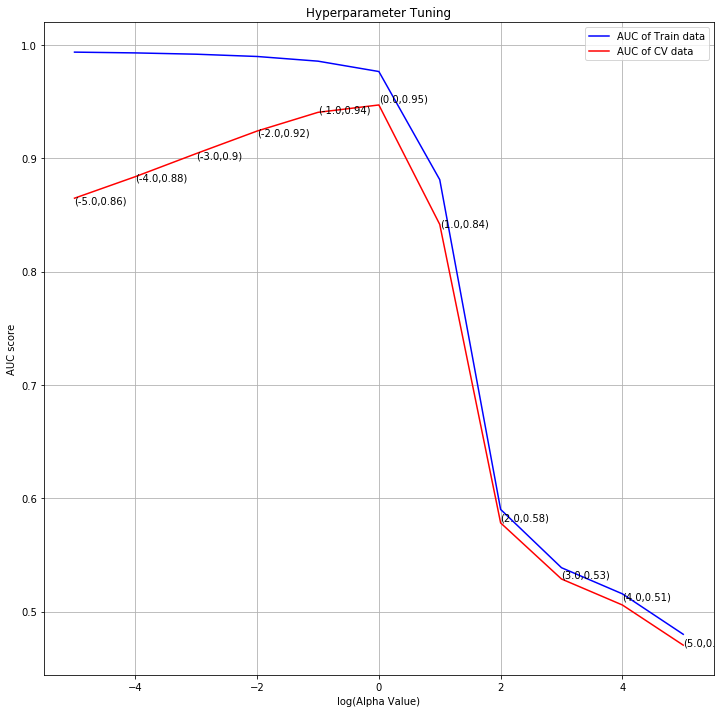

In [30]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=1, Model get a higgest auc score=0.95

In [31]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_bow=best_NB(best_alpha=1,train_vector=bow_train_vec1,\
                                                                                                                             train_label=y_train,test_vector=bow_test_vec1,\
                                                                                                                             test_label=y_test)

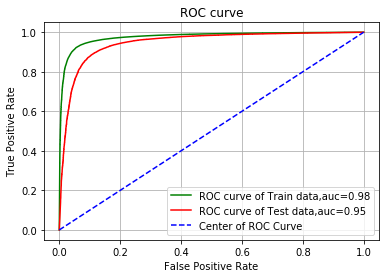

In [32]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

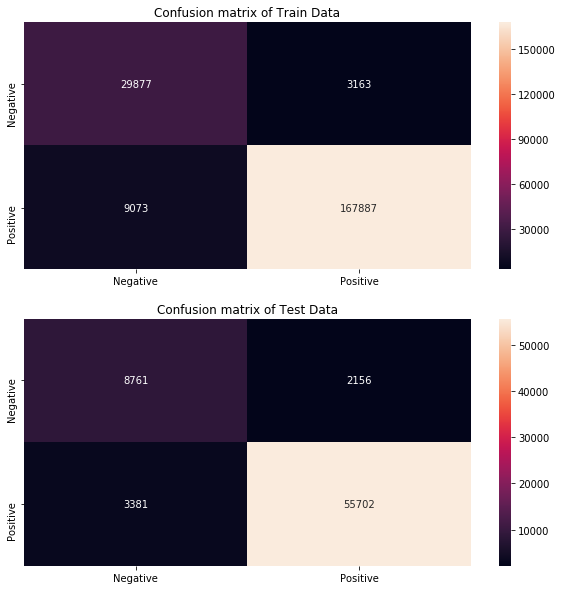

In [33]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.95

#### 6.3 TFIDF on Naive Bayes model

In [34]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=tfidf_train_vec1,train_label=y_train,\
                                            cv_vector=tfidf_cv_vec1,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


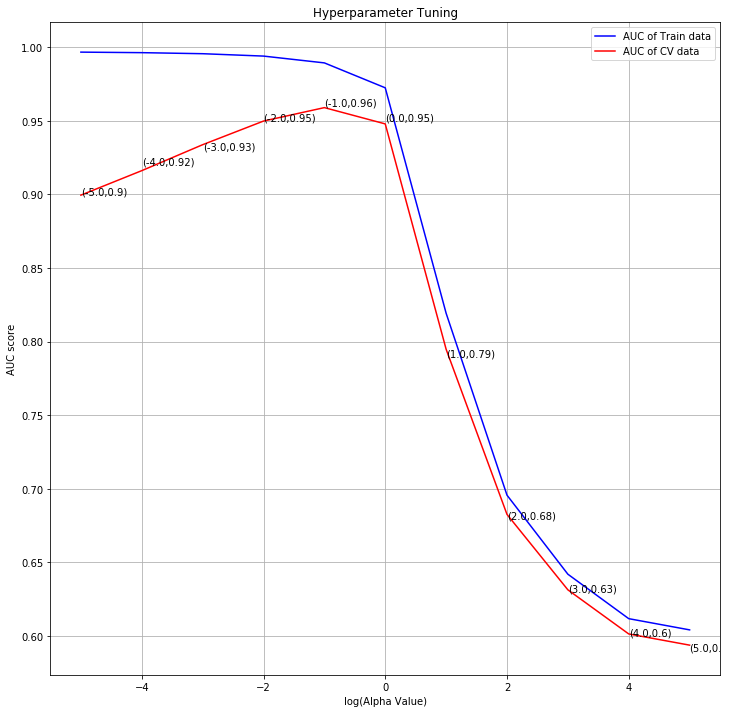

In [35]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=0.1, Model get a higgest auc score=0.96

In [36]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_tfidf=best_NB(best_alpha=0.1,train_vector=tfidf_train_vec1,\
                                                                                                                                 train_label=y_train,test_vector=tfidf_test_vec1,\
                                                                                                                                 test_label=y_test)

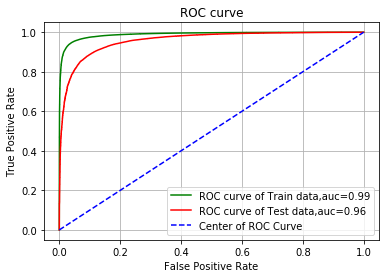

In [37]:
# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

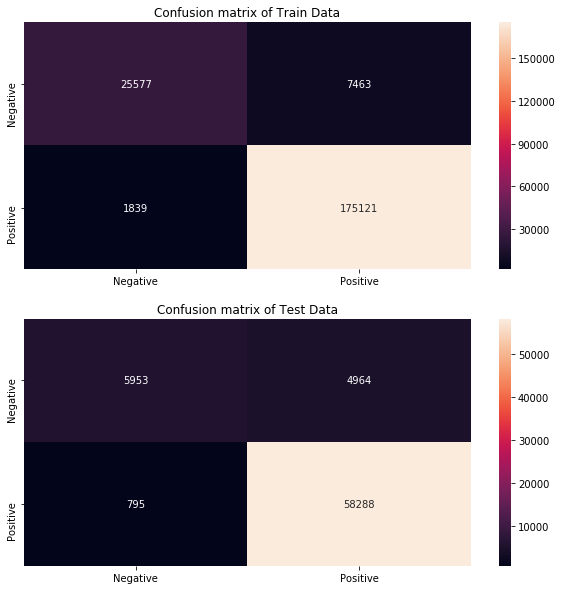

In [38]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter(alpha=0.1) on model, we get auc score of future unseen data is 0.96

#### 6.4 Model Observations:

In [39]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [40]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW","Multinomial Naive Bayes",1,0.95])
x.add_row(["TFIDF","Multinomial Naive Bayes",0.1,0.96])
print(x)

+------------+-------------------------+----------------+------+
| Vectorizer |          Model          | Hyperparameter | AUC  |
+------------+-------------------------+----------------+------+
|    BOW     | Multinomial Naive Bayes |       1        | 0.95 |
|   TFIDF    | Multinomial Naive Bayes |      0.1       | 0.96 |
+------------+-------------------------+----------------+------+


### 7. Feature Importance

#### 7.1 Feature Importance on Model (BOW)

In [47]:
class_return

array([0, 1], dtype=int64)

* So the first row belongs to negative class and second row belongs to positive class

In [44]:
p_class_bow=np.argsort(fi_bow[1])
n_class_bow=np.argsort(fi_bow[0])

In [52]:
# References
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

# Top 10 features of Positive class

print("Top 20 features of Positive class")
print("="*125)
print(np.take(bow_model.get_feature_names(),p_class_bow[::-1][:20]))
print(" ")

# Top 10 features of Negative class

print("Top 20 features of Negative class")
print("="*125)
print(np.take(bow_model.get_feature_names(),n_class_bow[::-1][:20]))

Top 20 features of Positive class
['not' 'like' 'tast' 'good' 'flavor' 'love' 'use' 'great' 'one' 'product'
 'tri' 'tea' 'coffe' 'make' 'get' 'would' 'food' 'time' 'buy' 'no']
 
Top 20 features of Negative class
['not' 'tast' 'like' 'product' 'would' 'one' 'flavor' 'tri' 'use' 'good'
 'coffe' 'no' 'get' 'buy' 'food' 'order' 'tea' 'even' 'box' 'amazon']


#### 7.2 Feature Importance on Model (TFIDF)

In [48]:
p_class_tfidf=np.argsort(fi_tfidf[1])
n_class_tfidf=np.argsort(fi_tfidf[0])

In [53]:
# Top 10 features of Positive class

print("Top 20 features of Positive class")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),p_class_tfidf[::-1][:20]))
print(" ")

# Top 10 features of Negative class

print("Top 20 features of Negative class")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),n_class_tfidf[::-1][:20]))

Top 20 features of Positive class
['not' 'great' 'love' 'tast' 'like' 'good' 'tea' 'flavor' 'coffe' 'use'
 'product' 'one' 'tri' 'make' 'get' 'food' 'would' 'price' 'best' 'buy']
 
Top 20 features of Negative class
['not' 'tast' 'like' 'product' 'would' 'flavor' 'one' 'coffe' 'tri' 'buy'
 'order' 'no' 'box' 'disappoint' 'tea' 'good' 'get' 'use' 'food' 'even']


### 8. Feature Engineering

#### 8.1 Adding Summary Text as a Feature with Review Text

* We consider summary text as a feature,we do preprocessing and featurization on the summary text and then we horizontally stack the summary text to the review text. so finally we get the extra word vector to improve our model.

##### 8.1.1 Summary Text Preprocessing

In [50]:
raw_summary_text_data=filter_data.Summary.values

In [51]:
# Preprocessing 

preprocessed_summary_text_data=[]
for i in tqdm(raw_summary_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_summary_text_data.append(b' '.join(k).decode())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:43<00:00, 8398.72it/s]


In [54]:
filter_data["Summary"]=preprocessed_summary_text_data

In [55]:
filter_data.shape

(364171, 10)

In [56]:
# we took the sample data size as 150k 

final_data=filter_data[:350000]
final_data.shape

(350000, 10)

##### 8.1.2. Data Splitting

In [57]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [58]:
X=final_data.Summary
Y=final_data.Score

In [59]:
x_1,x_test1,y_1,y_test1=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train1,x_cv1,y_train1,y_cv1=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train1.shape,y_train.shape)

print("cv data size")
print(x_cv1.shape,y_cv.shape)
print("Test data size")
print(x_test1.shape,y_test.shape)

 Train data Size
(210000,) (210000,)
cv data size
(70000,) (70000,)
Test data size
(70000,) (70000,)


##### 8.1.3. Featurization

* We only consider BOW and TFIDF. Because the Naive Bayes biggest assumption is Conditional independence. 

##### Bag of Words (BOW)

In [60]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5)

# BOW on Train data

bow_train_vec2=bow_model.fit_transform(x_train1)

# BOW on cv data

bow_cv_vec2=bow_model.transform(x_cv1)

# BOW on Test data

bow_test_vec2=bow_model.transform(x_test1)

In [61]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec2.get_shape()[1])

The size of BOW vectorizer
16608


##### TFIDF

In [62]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5)

# TFIDF on Train data 

tfidf_train_vec2=tfidf_model.fit_transform(x_train1)

# TFIDF on cv data

tfidf_cv_vec2=tfidf_model.transform(x_cv1)

# TFIDF on Test data

tfidf_test_vec2=tfidf_model.transform(x_test1)

In [63]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec2.get_shape()[1])

The size of TFIDF vectorizer
16608


##### 8.1.4 Horizontally stacking

In [64]:
# References 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html
# https://stackoverflow.com/questions/37716699/how-to-hstack-several-sparse-matrices-feature-matrices
import scipy as ss

##### Feature Engineering on BOW

In [65]:
# For Training Data
bow_train_vec=ss.sparse.hstack([bow_train_vec1,bow_train_vec2])


# For cv Data

bow_cv_vec=ss.sparse.hstack([bow_cv_vec1,bow_cv_vec2])


# For test Data

bow_test_vec=ss.sparse.hstack([bow_test_vec1,bow_test_vec2])


In [66]:
bow_train_vec

<210000x275393 sparse matrix of type '<class 'numpy.int64'>'
	with 13045243 stored elements in COOrdinate format>

##### Feature Engineering on TFIDF

In [67]:
# For Training Data
tfidf_train_vec=ss.sparse.hstack([tfidf_train_vec1,tfidf_train_vec2])


# For cv Data

tfidf_cv_vec=ss.sparse.hstack([tfidf_cv_vec1,tfidf_cv_vec2])


# For test Data

tfidf_test_vec=ss.sparse.hstack([tfidf_test_vec1,tfidf_test_vec2])


In [68]:
tfidf_train_vec

<210000x275393 sparse matrix of type '<class 'numpy.float64'>'
	with 13045243 stored elements in COOrdinate format>

##### 8.1.5  Feature Engineered BOW on Naive Bayes

In [69]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=bow_train_vec,train_label=y_train,\
                                            cv_vector=bow_cv_vec,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:33<00:00,  3.10s/it]


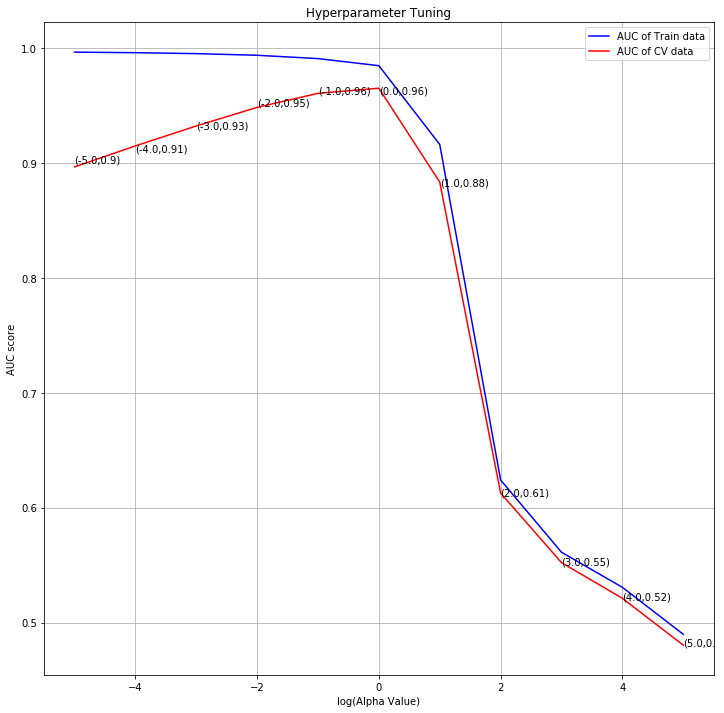

In [70]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=1, Model get a higgest auc score=0.96

In [102]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_bow_fe=best_NB(best_alpha=1,train_vector=bow_train_vec,\
                                                                                        train_label=y_train,test_vector=bow_test_vec,\
                                                                                        test_label=y_test)

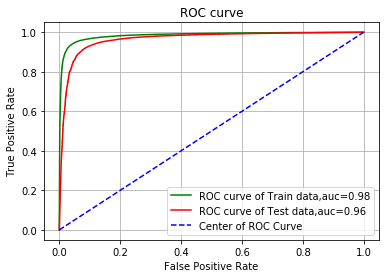

In [72]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

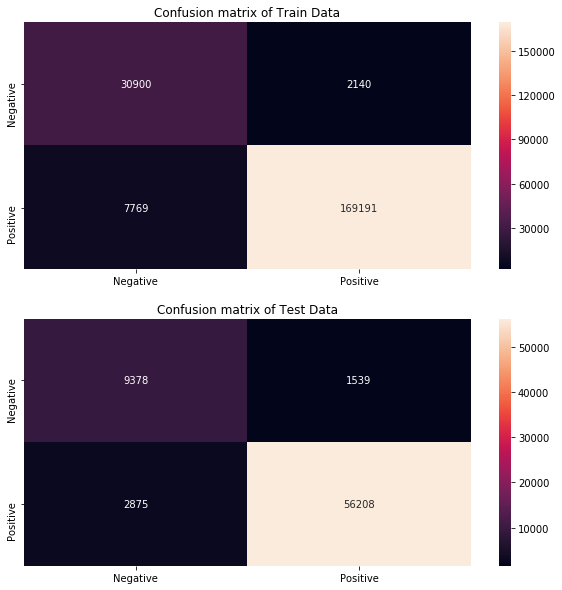

In [73]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.96

##### 8.1.5  Feature Engineered TFIDF on Naive Bayes

In [74]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=tfidf_train_vec,train_label=y_train,\
                                            cv_vector=tfidf_cv_vec,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:33<00:00,  3.09s/it]


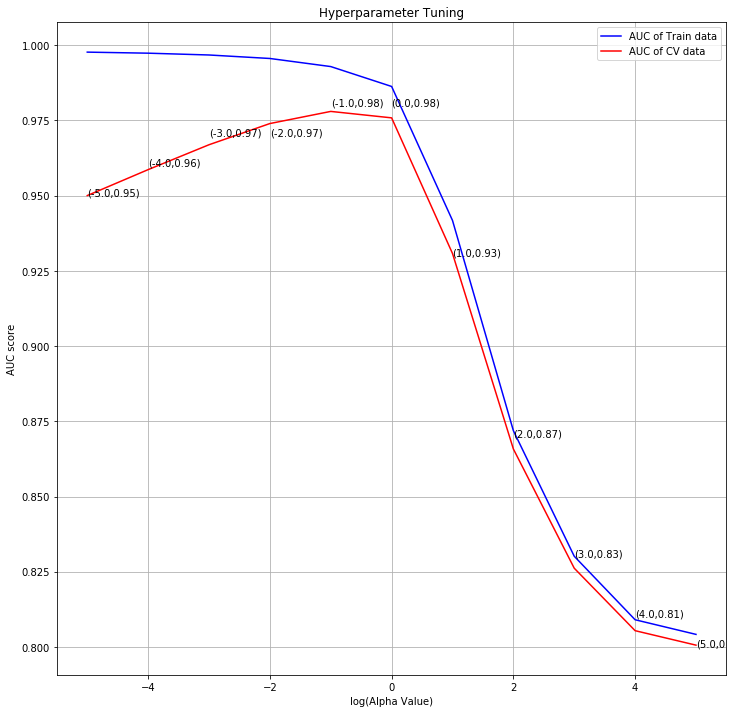

In [75]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=0.1, Model get a higgest auc score=0.98

In [103]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_tfidf_fe=best_NB(best_alpha=0.1,train_vector=tfidf_train_vec,\
                                                                                        train_label=y_train,test_vector=tfidf_test_vec,\
                                                                                        test_label=y_test)

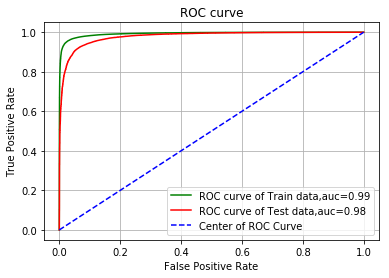

In [77]:
# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

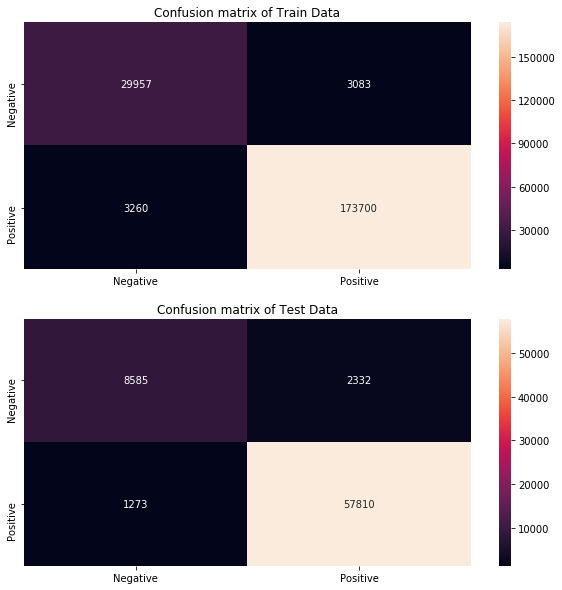

In [78]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter(alpha=0.1) on model, we get auc score of future unseen data is 0.98

#### 8.2 Adding Review Text length as a feature with Review and Summary Text vector

In [79]:
# Lengh of the Words in Each Review document

a=[]
for i in preprocessed_text_data:
    a.append(len(i.split()))

In [80]:
# Adding Length as a new Feature in DataFrame

filter_data["Length"]=a

##### 8.2.1Column Standardization using Standardization Formula:

* $\ (Xi-mean)/std $

In [81]:
mean1=filter_data.Length.mean()
std1=filter_data.Length.std()

In [82]:
b=a
c=[]
for i in b:
    stand=(i-mean1)/std1
    c.append(abs(stand))

In [83]:
filter_data.Length=c

##### 8.2.2. Data Splitting

In [84]:
# we took the sample data size as 150k 

final_data=filter_data[:350000]
final_data.shape

(350000, 11)

In [85]:
X=final_data.Length
Y=final_data.Score

In [86]:
x_1,x_test2,y_1,y_test2=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train2,x_cv2,y_train2,y_cv2=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train2.shape,y_train.shape)

print("cv data size")
print(x_cv2.shape,y_cv.shape)
print("Test data size")
print(x_test2.shape,y_test.shape)

 Train data Size
(210000,) (210000,)
cv data size
(70000,) (70000,)
Test data size
(70000,) (70000,)


##### 8.2.3 Horizontally stacking

##### Feature Engineering on BOW

In [87]:
# hstack takes list of list values. so we convert list to list of list

# For BOW
a_train=[]
for i in x_train2.values:
    b=[]
    b.append(i)
    a_train.append(b)
    
a_cv=[]
for i in x_cv2.values:
    b=[]
    b.append(i)
    a_cv.append(b)
    
a_test=[]
for i in x_test2.values:
    b=[]
    b.append(i)
    a_test.append(b)

In [88]:
# For Training Data
bow_train_vec_fe=ss.sparse.hstack([bow_train_vec,a_train])


# For cv Data

bow_cv_vec_fe=ss.sparse.hstack([bow_cv_vec,a_cv])


# For test Data

bow_test_vec_fe=ss.sparse.hstack([bow_test_vec,a_test])

##### Feature Engineering on TFIDF

In [89]:
# For Training Data
tfidf_train_vec_fe=ss.sparse.hstack([tfidf_train_vec1,a_train])


# For cv Data

tfidf_cv_vec_fe=ss.sparse.hstack([tfidf_cv_vec1,a_cv])


# For test Data

tfidf_test_vec_fe=ss.sparse.hstack([tfidf_test_vec1,a_test])


##### 8.2.4  Feature Engineered BOW on Naive Bayes

In [90]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=bow_train_vec_fe,train_label=y_train,\
                                            cv_vector=bow_cv_vec_fe,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.95s/it]


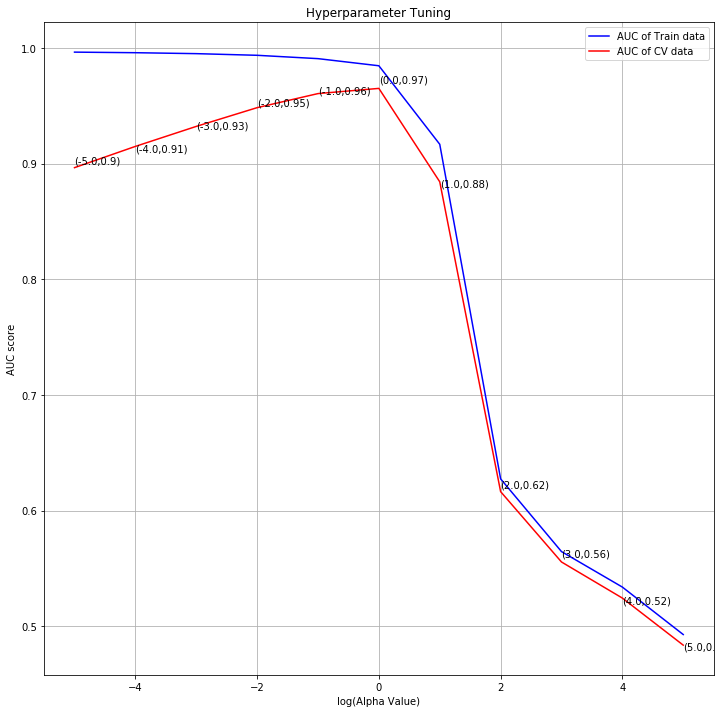

In [91]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=1, Model get a higgest auc score=0.97

In [104]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_bow_fe=best_NB(best_alpha=1,train_vector=bow_train_vec_fe,\
                                                                                        train_label=y_train,test_vector=bow_test_vec_fe,\
                                                                                        test_label=y_test)

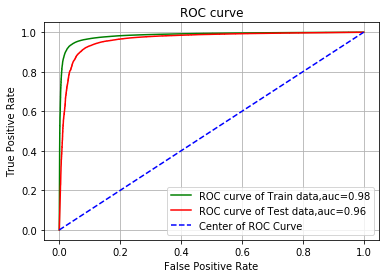

In [93]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

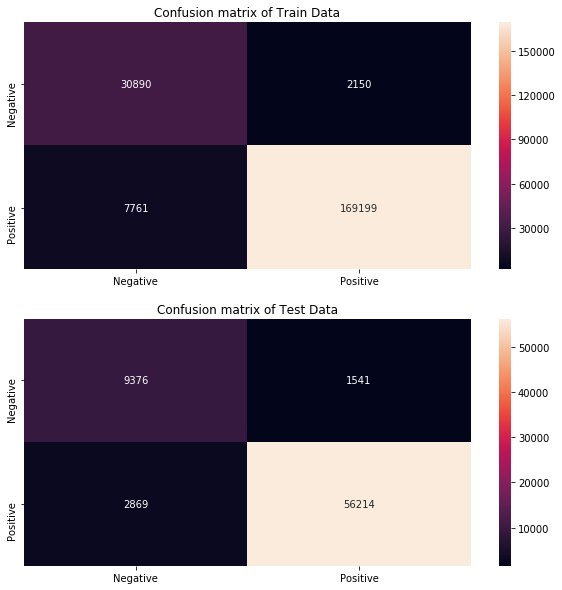

In [94]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.96

##### 8.2.5  Feature Engineered TFIDF on Naive Bayes

In [95]:
# Hyper parameter Tuning

alpha_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
auc_train_score,auc_cv_score=multinomial_NB(alpha_values=alpha_val,train_vector=tfidf_train_vec_fe,train_label=y_train,\
                                            cv_vector=tfidf_cv_vec_fe,cv_label=y_cv)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.96s/it]


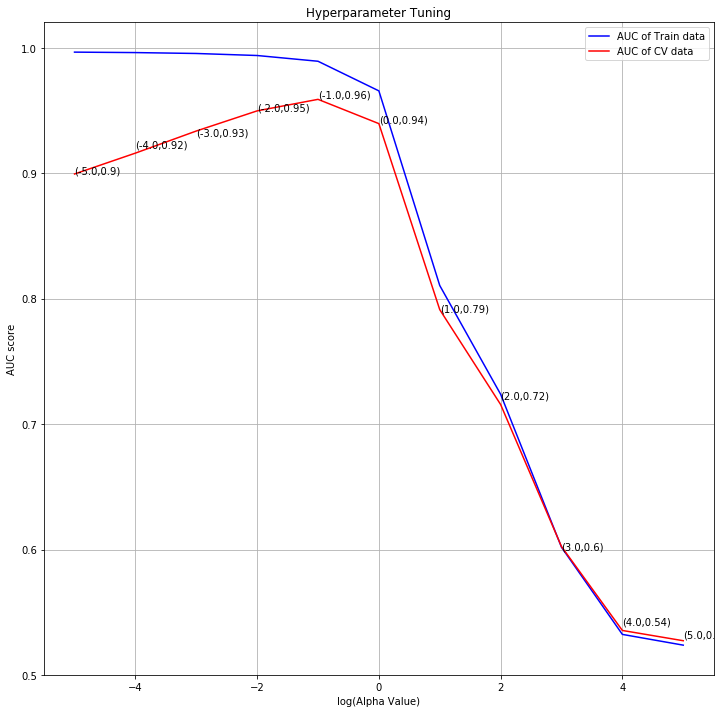

In [96]:
# plotting auc score

auc_score(alpha_value=log_alpha,auc_train=auc_train_score,auc_cv=auc_cv_score)

##### Observation:

* When alpha=0.1, Model get a higgest auc score=0.96

In [105]:
# applying best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi_tfidf_fe=best_NB(best_alpha=0.1,train_vector=tfidf_train_vec_fe,\
                                                                                        train_label=y_train,test_vector=tfidf_test_vec_fe,\
                                                                                        test_label=y_test)

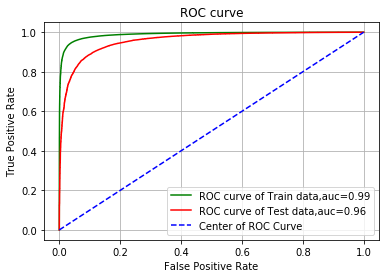

In [98]:
# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,x1=0,y1=0.98,x2=1,y2=0.94,\
         text1=str(round(auc_train,2)),text2=str(round(auc_test,2)))

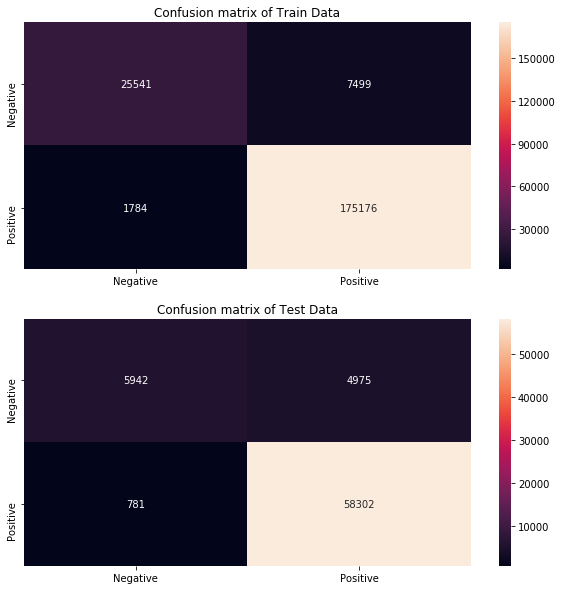

In [99]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter(alpha=0.1) on model, we get auc score of future unseen data is 0.96

#### 8.3 Model Observations After Feature Engineering

In [100]:
y = PrettyTable()
z= PrettyTable()
print ("After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
y.add_row(["BOW","Multinomial Naive Bayes",1,0.96])
y.add_row(["TFIDF","Multinomial Naive Bayes",0.1,0.98])
print(y)
print(' ')
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["BOW","Multinomial Naive Bayes",1,0.96])
z.add_row(["TFIDF","Multinomial Naive Bayes",0.1,0.96])
print(z)

After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+-------------------------+----------------+------+
| Vectorizer |          Model          | Hyperparameter | AUC  |
+------------+-------------------------+----------------+------+
|    BOW     | Multinomial Naive Bayes |       1        | 0.96 |
|   TFIDF    | Multinomial Naive Bayes |      0.1       | 0.98 |
+------------+-------------------------+----------------+------+
 
Feature Engineering (Review Text + Summary + Length)
 
+------------+-------------------------+----------------+------+
| Vectorizer |          Model          | Hyperparameter | AUC  |
+------------+-------------------------+----------------+------+
|    BOW     | Multinomial Naive Bayes |       1        | 0.96 |
|   TFIDF    | Multinomial Naive Bayes |      0.1       | 0.96 |
+------------+-------------------------+----------------+------+


* After applying Feature Engineering on the Naive Bayes Model, The Summary Text is slightly improve model performance. But the length does not make any impact on the model. So we just ignore the length feature

### 9. Conclusion

In [101]:
y = PrettyTable()
z= PrettyTable()
print ("1. Before Applying Feature Engineering on Model(Review Text)")
print(' ')
print(x)
print(' ')
print ("2. After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
y.add_row(["BOW","Multinomial Naive Bayes",1,0.96])
y.add_row(["TFIDF","Multinomial Naive Bayes",0.1,0.98])
print(y)
print(' ')
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["BOW","Multinomial Naive Bayes",1,0.96])
z.add_row(["TFIDF","Multinomial Naive Bayes",0.1,0.96])
print(z)

# Important Features
s= PrettyTable()
s.field_names = ["Original Score", "Negative_Probability", "Positive_Probability"]
s.add_row([1,0.0,1.0])
s.add_row([0,1.0,0.0])

v= PrettyTable()
v.field_names = ["Original Score", "Negative_Probability", "Positive_Probability"]
v.add_row([1,0.117, 0.880])
v.add_row([0,0.980,0.016])

1. Before Applying Feature Engineering on Model(Review Text)
 
+------------+-------------------------+----------------+------+
| Vectorizer |          Model          | Hyperparameter | AUC  |
+------------+-------------------------+----------------+------+
|    BOW     | Multinomial Naive Bayes |       1        | 0.95 |
|   TFIDF    | Multinomial Naive Bayes |      0.1       | 0.96 |
+------------+-------------------------+----------------+------+
 
2. After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+-------------------------+----------------+------+
| Vectorizer |          Model          | Hyperparameter | AUC  |
+------------+-------------------------+----------------+------+
|    BOW     | Multinomial Naive Bayes |       1        | 0.96 |
|   TFIDF    | Multinomial Naive Bayes |      0.1       | 0.98 |
+------------+-------------------------+----------------+------+
 
Feature Engineering (Review Text + Summary + Length)
 
+--

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 350k sample data points for further process. and then split the 350k data points using simple cross validation technique. Train= 210000, CV=70000, Test=70000.

##### Featurization:

* Then apply the data points on BOW and TFIDF for converting text to vector.
* Only consider BoW and TFIDF as a featurization technique, because the naive bayes works based on conditional independence assumption.

#####  Naive Bayes Model: 

* Then apply these vector on Multinomial Naive Bayes(MNB) we get the Model performance as MNB(BOW)=0.95 and MNB(TFIDF)=0.96.

##### Feature Importance:

* Then took the top 10 important features both positive and negative class.

##### Feature Engineering:

* We will apply feature engineering for improve the MNB Model performance. For consider Summary and Review Text Length as a feature.
* After applying Feature Engineering on the Naive Bayes Model, The Summary Text is slightly improve model performance. But the length does not make any impact on the model. So we just ignore the length feature for future improvement.
* Multinomial Naive Bayes Model using TFIDF gives better performance compared to Multinomial Naive Bayes Model using BOW.